In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path
from typing import Optional

import arviz as az
import numpyro

from hbmep_paper.models.human.utils import load_data

#### Load data and preprocess

In [3]:
dir = "/home/vishu/data"
sc_approach = "posterior"

df = load_data(dir=dir, sc_approach=sc_approach)

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
data = DataClass(config)

# subset = ["scapptio001", "cornptio017", "cornptio016", "cornptio015", "cornptio014", "cornptio013", "cornptio012", "cornptio011", "cornptio010", "cornptio009", "cornptio008", "cornptio007", "cornptio006", "cornptio005", "cornptio004", "cornptio003", "cornptio002", "cornptio001"]
# subset = ["scapptio001"]

# subset = ["cornptio011", "cornptio017"]
# df = load_data(data=data, muscle="Triceps", subset=subset)
df = load_data(data=data, muscle="Triceps")

df, encoder_dict, _ = data.build(df)


2023-06-21 10:39:46,695 - hb_mep.utils.utils - INFO - func:load_data took: 0.15 sec
2023-06-21 10:39:46,697 - hb_mep.data_access.core - INFO - Processing data ...
2023-06-21 10:39:46,699 - hb_mep.data_access.core - INFO - Removed 1 observation(s) containing zero AUC response
2023-06-21 10:39:46,709 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-06-21 10:39:46,710 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


### Mixture Model

In [5]:
class MixedEffects(Baseline):
    def __init__(self, config: HBMepConfig):
        super(MixedEffects, self).__init__(config=config)
        self.name = "Mixed_Effects"

        self.columns = [PARTICIPANT, FEATURES[1]]
        self.x = np.linspace(0, 15, 100)
        self.xpad = 2

    @timing
    def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
        """
        Run MCMC inference
        """
        response = df[RESPONSE].to_numpy()
        self.n_response = response.shape[-1]

        intensity = df[INTENSITY].to_numpy().reshape(-1,)
        participant = df[PARTICIPANT].to_numpy().reshape(-1,)
        feature1 = df[FEATURES[1]].to_numpy().reshape(-1,)

        # MCMC
        nuts_kernel = NUTS(self._model)
        mcmc = MCMC(nuts_kernel, **self.config.MCMC_PARAMS)
        rng_key = jax.random.PRNGKey(self.random_state)
        logger.info(f"Running inference with {self.name} ...")
        mcmc.run(rng_key, intensity, participant, feature1, response)
        posterior_samples = mcmc.get_samples()

        return mcmc, posterior_samples

    def _get_threshold_estimates(
        self,
        combination: tuple,
        posterior_samples: dict,
        prob: float = .95
    ):
        threshold_posterior = posterior_samples[site.a][
            :, combination[1], combination[0], :
        ]
        threshold = threshold_posterior.mean(axis=0)
        hpdi_interval = hpdi(threshold_posterior, prob=prob)
        return threshold, threshold_posterior, hpdi_interval

    def predict(
        self,
        intensity: np.ndarray,
        combination: tuple,
        posterior_samples: Optional[dict] = None,
        num_samples: int = 100
    ):
        predictive = Predictive(model=self._model, num_samples=num_samples)
        if posterior_samples is not None:
            predictive = Predictive(
                model=self._model, posterior_samples=posterior_samples
            )

        participant = np.repeat([combination[0]], intensity.shape[0])
        feature1 = np.repeat([combination[1]], intensity.shape[0])

        predictions = predictive(
            self.rng_key,
            intensity=intensity,
            participant=participant,
            feature0=feature1
        )
        return predictions

    def _model(self, intensity, participant, feature0, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        n_data = intensity.shape[0]
        n_participant = np.unique(participant).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate("n_response", self.n_response, dim=-1):
            """ Delta """
            delta_mean = numpyro.sample(site.delta_mean, dist.Normal(0, 10))
            delta_scale = numpyro.sample(site.delta_scale, dist.HalfNormal(2.0))

            """ Baseline """
            baseline_mean_global_mean = numpyro.sample(
                "baseline_mean_global_mean",
                dist.HalfNormal(2.0)
            )
            baseline_scale_global_scale = numpyro.sample(
                site.baseline_scale_global_scale,
                dist.HalfNormal(2.0)
            )

            baseline_scale = numpyro.sample(
                site.baseline_scale,
                dist.HalfNormal(baseline_scale_global_scale)
            )
            baseline_mean = numpyro.sample(
                site.baseline_mean,
                dist.TruncatedDistribution(dist.Normal(baseline_mean_global_mean, baseline_scale), low=0)
            )

            with numpyro.plate("n_participant", n_participant, dim=-2):
                baseline = numpyro.sample(
                    site.baseline,
                    dist.TruncatedNormal(baseline_mean, baseline_scale, low=0)
                )
                delta = numpyro.sample(site.delta, dist.Normal(delta_mean, delta_scale))

                b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(10))

                h_scale = numpyro.sample("h_scale", dist.HalfNormal(10))
                v_scale = numpyro.sample("v_scale", dist.HalfNormal(10))

                lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(2))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.array([baseline, baseline + delta])
                    )
                    b = numpyro.sample(site.b, dist.HalfCauchy(b_scale))

                    h = numpyro.sample("h", dist.HalfNormal(h_scale))
                    v = numpyro.sample("v", dist.HalfCauchy(v_scale))

                    lo = numpyro.sample(site.lo, dist.HalfNormal(lo_scale))

                    gamma_scale_offset = numpyro.sample(
                        "gamma_scale_offset", dist.HalfCauchy(2.5)
                    )
                    gamma_scale_slope = numpyro.sample(
                        "gamma_scale_slope", dist.HalfCauchy(2.5)
                        )

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature0, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature0, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature0, participant], v[feature0, participant]) - 1) * \
                    jnp.exp(-b[feature0, participant] * (intensity - a[feature0, participant])),
                    1 / v[feature0, participant]
                )
            )
        )

        scale = numpyro.deterministic(
            "scale",
            gamma_scale_offset[feature0, participant] + \
            gamma_scale_slope[feature0, participant] * (1 / mean)
        )

        """ Penalty """
        penalty = 5 * (jnp.fabs(baseline + delta) - (baseline + delta))
        numpyro.factor(site.penalty, -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(mean * scale, scale).to_event(1),
                obs=response_obs
            )

#### Initialize model

In [6]:
model = MixedEffects(config)

# model.predictive_check(df=df);

2023-06-21 10:39:46,758 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-06-21 10:39:46,759 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-21 10:39:46,759 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-06-21 10:39:46,760 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-06-21 10:39:46,760 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-06-21 10:39:46,842 - __main__ - INFO - Running inference with Mixed_Effects ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Diagnostics

In [ ]:
mcmc.print_summary(prob=.95)


                                    mean       std    median      2.5%     97.5%     n_eff     r_hat
                      b[0,0,0]      4.03     64.60      1.82      0.03     13.10  21701.28      1.00
                      b[0,1,0]      4.44      5.24      3.09      0.88     11.88   3031.05      1.00
                      b[0,2,0]      1.04      2.77      0.43      0.00      3.72   1241.24      1.00
                      b[0,3,0]      2.52      5.46      1.13      0.03      8.75   4867.95      1.00
                      b[0,4,0]     15.89     32.87      6.39      0.16     59.54   1761.57      1.00
                      b[0,5,0]     38.18    415.27      5.16      0.00     93.84   8750.11      1.00
                      b[0,6,0]     19.73     29.76      8.75      0.20     81.90   2897.93      1.00
                      b[0,7,0]      5.95     11.66      2.17      0.24     22.20   2563.03      1.00
                      b[0,8,0]     89.64    115.39     44.67      3.30    357.59   1490.50

#### Plot fitted curves

2023-06-21 07:16:05,777 - hb_mep.utils.utils - INFO - func:plot took: 46.25 sec


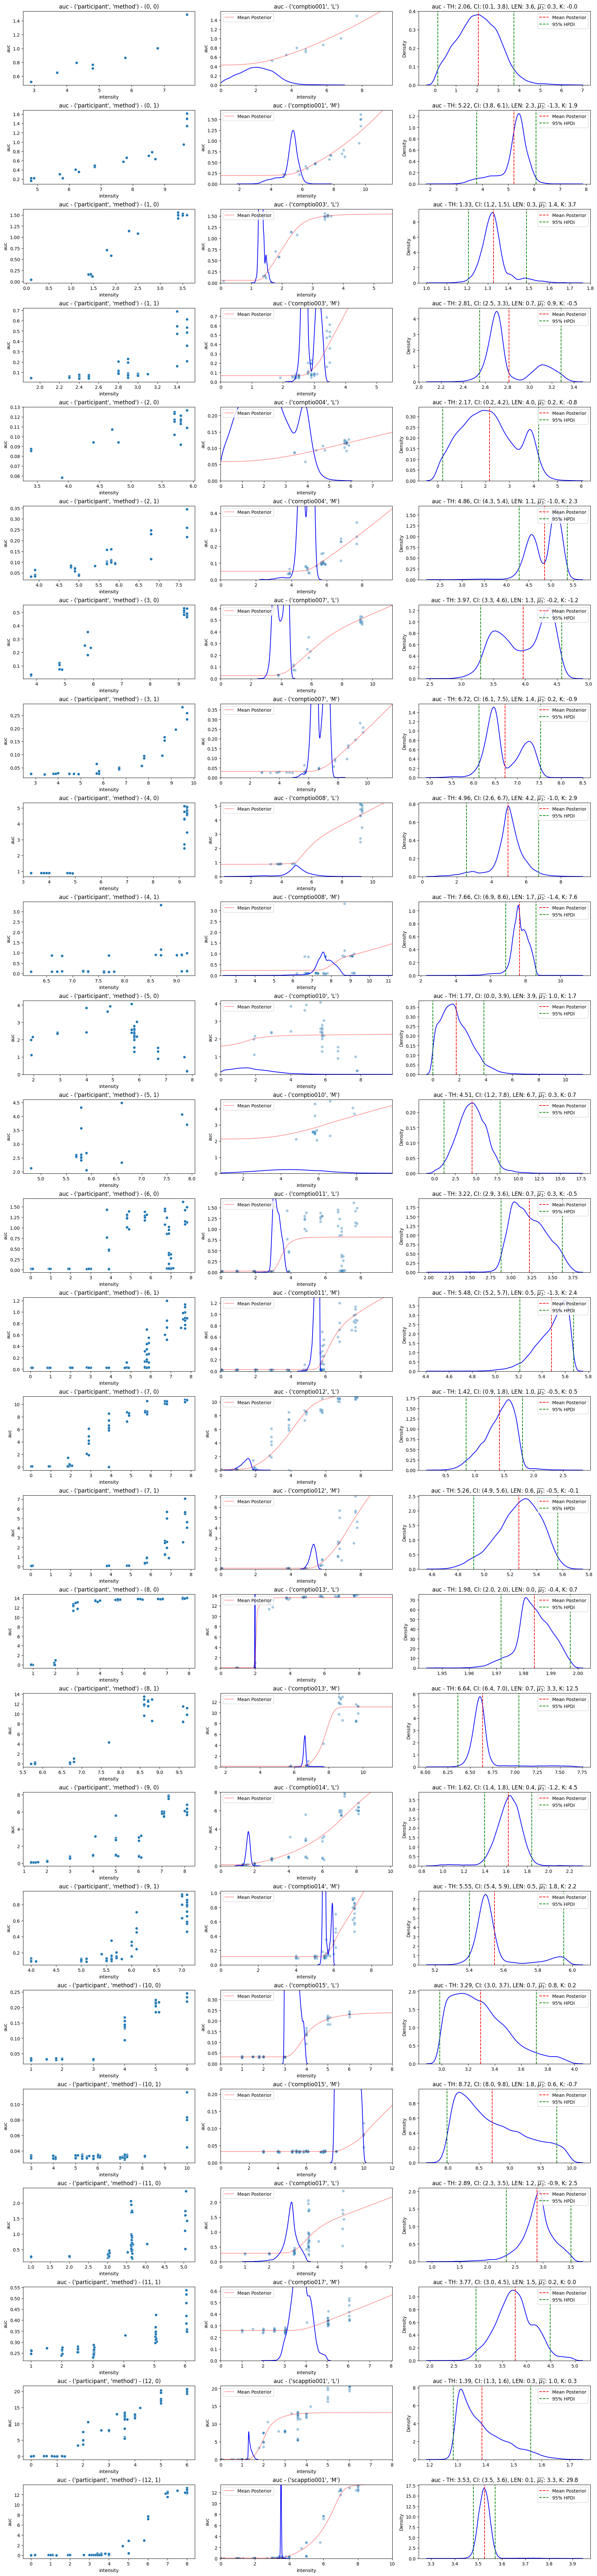

In [ ]:
# model.plot(df=df, posterior_samples=posterior_samples, encoder_dict=encoder_dict);

#### Posterior Predictive Check

2023-06-21 07:17:15,974 - hb_mep.utils.utils - INFO - func:predictive_check took: 55.58 sec


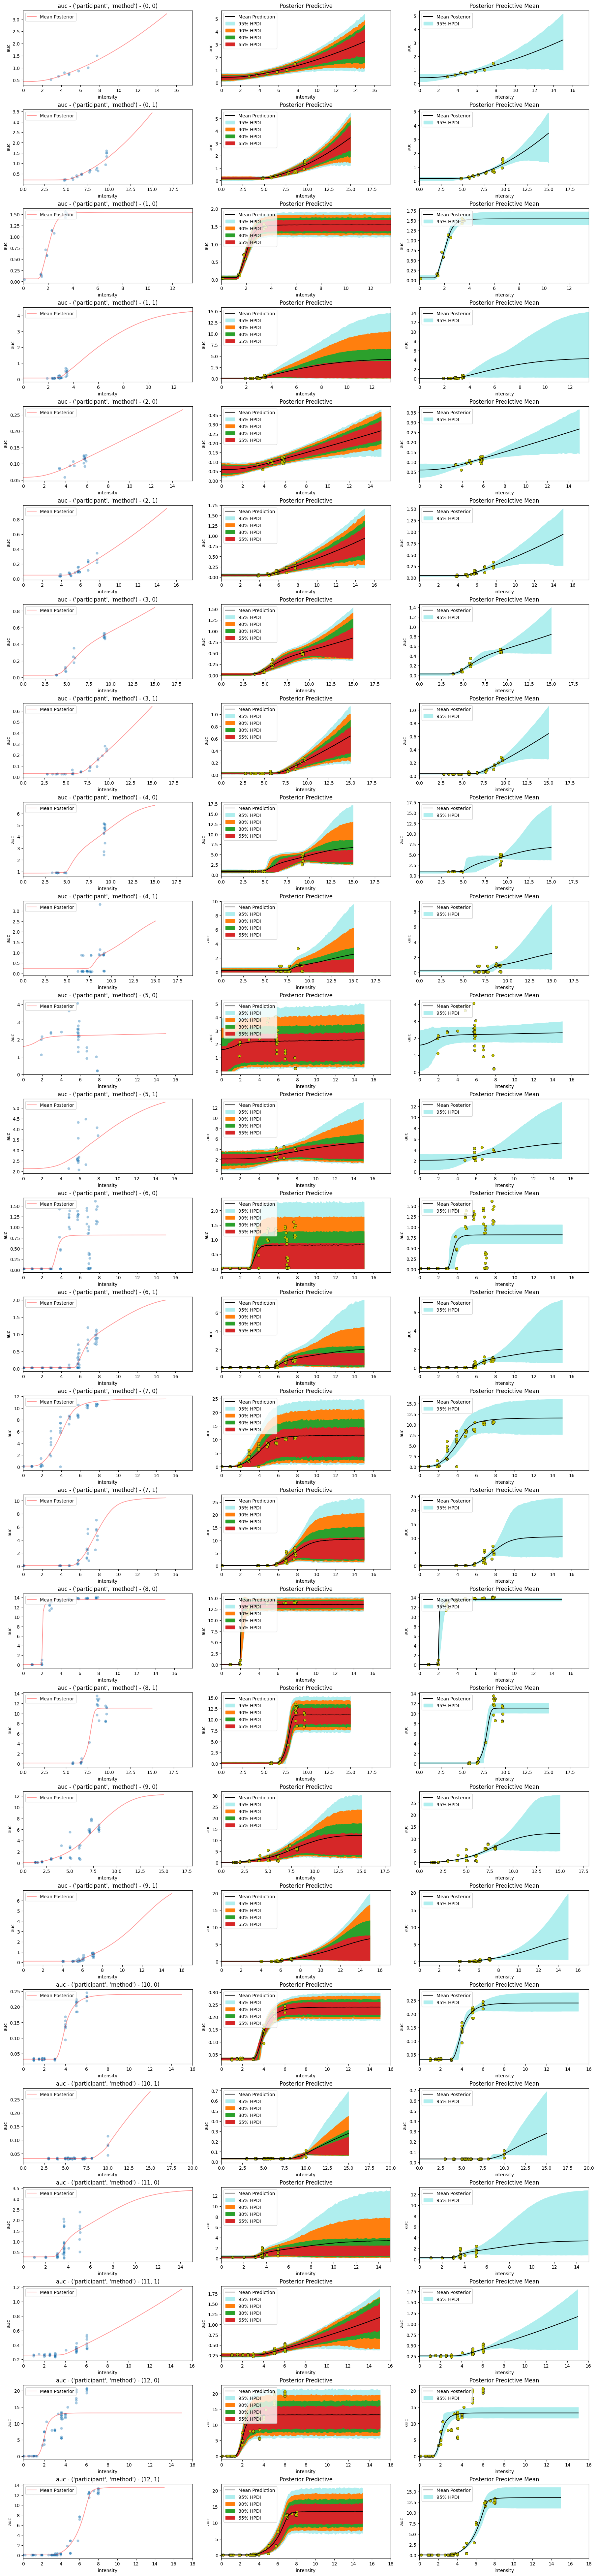

In [ ]:
# model.predictive_check(df=df, posterior_samples=posterior_samples);

#### Information Criterion

In [ ]:
numpyro_data = az.from_numpyro(mcmc)

##### Loo

In [ ]:
az.loo(numpyro_data, var_name="obs")

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1164 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   919.50    92.83
p_loo      207.69        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1107   95.1%
 (0.5, 0.7]   (ok)         36    3.1%
   (0.7, 1]   (bad)         8    0.7%
   (1, Inf)   (very bad)   13    1.1%

##### WAIC

In [ ]:
az.waic(numpyro_data, var_name="obs")

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1164 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   938.76    91.32
p_waic      188.43        -

There has been a warning during the calculation. Please check the results.

In [ ]:
delta_mean = posterior_samples["delta_mean"].reshape(-1,)

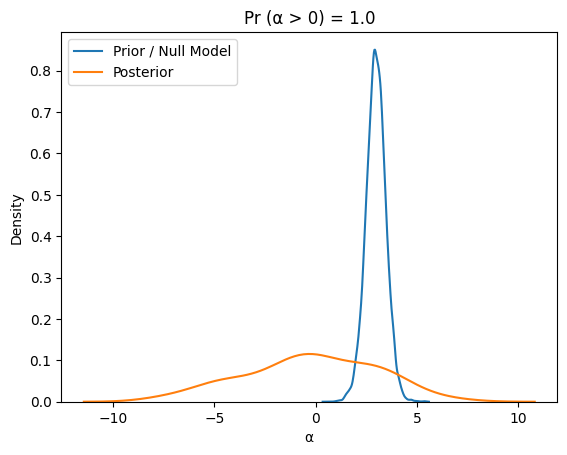

In [ ]:
samples = dist.Normal(0, 3).sample(model.rng_key, sample_shape=(100,))

import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(delta_mean, label="Prior / Null Model")
sns.kdeplot(samples, label="Posterior")

plt.title(f"Pr (Midline > Lateral) = {(delta_mean > 0).mean()}")
plt.xlabel("α")
plt.legend(loc="upper left")